In [3]:
# init
import pandas as pd
import numpy as np
from tqdm import tqdm
# import nltk
# nltk.download()

Import Data

In [ ]:
import glob
import os

pubmed = []

# import pubmed
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/pubmed/", "*.txt"))

for docPath in docList:
    # get doc file name
    docName = os.path.basename(docPath).split('.')[0]
    
    with open(docPath) as doc:
        # insert [class, docs, feature]
        pubmed.append([docName[:3], docName, doc.read().replace('\n', ' ')])

# print(pubmed)

# make dataframe
dataframe = pd.DataFrame(data=pubmed, columns=['class', 'document', 'feature']) 

# export pubmed raw
dataframe.to_csv('pubmed/raw.csv', index=False)

Dataframe raw

In [ ]:
# read csv
dataRaw = pd.read_csv('pubmed/raw.csv')
# get feature
features = dataRaw.loc[:, 'feature']
dataRaw

Preprocesing

In [28]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# cleaning
def cleaning(features):
    result = []
    for feature in features:
        regex = re.sub(r'[^a-zA-Z\s]', '', feature)
        result.append(regex)
    return result

# case folding
def caseFolding(features):
    result = []
    for feature in features:
        lower = feature.lower()
        result.append(lower)
    return result

# tokenization
def tokenization(features):
    result = []
    for feature in features:
        token = word_tokenize(feature)
        result.append(token)
    return result

# stopwords removal
def stopWords(features):
    result = []
    stopWords = set(stopwords.words('english'))
    for token in features:
        cleanedFeature = [feature for feature in token if feature not in stopWords]
        result.append(cleanedFeature)
    return result

In [ ]:
# preprocessing
def preprocessing(features):
    clean = cleaning(features)
    case = caseFolding(clean)
    token = tokenization(case)
    preprocessed = stopWords(token)
    
preprocessed = preprocessing(features)
# print(preprocessed)

# export pubmed clean
for i in range(len(preprocessed)):
    dataRaw.loc[i, 'feature'] = ' '.join(preprocessed[i])
dataRaw.to_csv('pubmed/clean.csv', index=False)

In [ ]:
# read csv
dataClean = pd.read_csv('pubmed/clean.csv')
# get feature
features = dataClean.loc[:, 'feature']
dataClean

Feature Forming

In [ ]:
from textblob import TextBlob

# BOAW
dataClean.rename(columns={'feature': 'BOAW'}, inplace=True)

for i in tqdm(range(len(features))):
    # BON
    dataClean.loc[i, 'BON'] = ' '.join(TextBlob(features[i]).noun_phrases)
    # BONA
    dataClean.loc[i, 'BONA'] = ' '.join([word for (word, tag) in TextBlob(features[i]).tags if tag[:2]=='NN' or tag[:2]=='JJ'])

# print(dataClean)

dataClean.to_csv('pubmed/formed.csv', index=False)

In [2]:
# read csv
dataFormed = pd.read_csv('pubmed/formed.csv')
# get features
classes = dataFormed.loc[:, 'class']
boaw = dataFormed.loc[:, 'BOAW']
bon = dataFormed.loc[:, 'BON']
bona = dataFormed.loc[:, 'BONA']
dataFormed

,class,document,BOAW,BON,BONA
0,ALZ,ALZ1,reduced amounts immunoreactive somatostatin te...,amounts immunoreactive somatostatin temporal c...,reduced amounts immunoreactive somatostatin te...
1,ALZ,ALZ10,diagnostic criteria primary neuronal degenerat...,diagnostic criteria primary neuronal degenerat...,diagnostic criteria primary neuronal degenerat...
2,ALZ,ALZ100,cacetylcholine synthesis ccarbon dioxide produ...,cacetylcholine synthesis ccarbon dioxide produ...,cacetylcholine synthesis ccarbon dioxide produ...
3,ALZ,ALZ1000,pattern reading deterioration dementia alzheim...,pattern reading deterioration dementia alzheim...,pattern deterioration dementia alzheimer type ...
4,ALZ,ALZ101,cerebral blood flow metabolic rate oxygen gluc...,cerebral blood flow metabolic rate oxygen gluc...,cerebral blood flow metabolic rate oxygen gluc...
...,...,...,...,...,...
3995,HIV,HIV3996,major histocompatibility complex genes influen...,major histocompatibility complex genes outcome...,major histocompatibility complex genes influen...
3996,HIV,HIV3997,hiv infection cohort haemophilic patients cour...,hiv infection cohort haemophilic patients cour...,hiv infection cohort haemophilic patients cour...
3997,HIV,HIV3998,evolution definition aids main classifications...,evolution definition aids main classifications...,evolution definition aids main classifications...
3998,HIV,HIV3999,human immunodeficiency virus glycoproteins gp ...,human immunodeficiency virus glycoproteins gp ...,human immunodeficiency virus glycoproteins gp ...


Feature Selection

In [4]:
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import spdiags

In [7]:
# TF-RF
def tf_rf(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # get classes weights
    clsVec = LabelBinarizer()
    cls = clsVec.fit_transform(classes)

    if cls.shape[1] == 1:
        cls = np.append(1 - cls, cls, axis=1)

    # count rf
    feature = ((cls.T * tf) > 0).astype(np.float64)

    for i in range(cls.shape[1]):
        # feature.sum(axis=0) - feature[i] is the sum of all rows except i
        feature[i] /= np.maximum(1., feature.sum(axis=0) - feature[i])

    rf = np.mean(np.log2(2 + feature, out=feature), axis=0)

    # count tf-rf & transform
    n_features = rf.shape[0]
    tfRf = tf * spdiags(rf, 0, n_features, n_features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tfRf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count weight by class
    mean = df.groupby('class').mean()
    result = (mean/mean.max()).sum()
    print(result)

    # select minimum weighted features
    # selected = []
    # for i in range(len(result)):
    #     if result[i] != 0 and result[i] == np.min(result):
    #         selected.append(df.columns[i])
    # return selected

rfx = tf_rf(bona, classes)
# print(rfx)

def symbolic_relevance(features, classes):
    # get sfs
    # sfs = sfs(features)

    # get tf-rf
    tfrf = tf_rf(features, classes)

    # intersect features
    selected = [word for word in sfs if word in tfrf]

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

aa               1.666667
aab              1.000000
aabc             1.000000
aac              1.000000
aaf              1.600000
                   ...   
zygomycosis      1.000000
zygotic          1.000000
zymosan          1.000000
zypab            1.000000
zytologisches    1.000000
Length: 18357, dtype: float64


In [ ]:
# BONA > SR
# bona_sr = symbolic_relevance(bona, classes)
bona_sr = tf_rf(bona, classes)

In [45]:
# save csv
for i in range(len(dataFormed)):
    # BOAW
    # dataFormed.loc[i, 'BOAW_SR'] = ' '.join(boaw_sr[i])
    # BON
    # dataFormed.loc[i, 'BON_SR'] = ' '.join(bon_sr[i])
    # BONA
    dataFormed.loc[i, 'BONA_SR'] = ' '.join(bona_sr[i])

dataFormed.to_csv('pubmed/selected.csv', index=False)

In [5]:
# read csv
dataSelected = pd.read_csv('pubmed/selected.csv')
# get features
classes = dataSelected.loc[:, 'class']
# bona_sr = dataSelected.loc[:, 'BONA_SR']
bona_sr = dataSelected.loc[:, 'BONA_TFRF']
dataSelected

,class,document,BONA_TFRF
0,ALZ,ALZ1,immunoreactive somatostatin senile dementia po...
1,ALZ,ALZ10,diagnostic primary degeneration alzheimers att...
2,ALZ,ALZ100,cacetylcholine synthesis ccarbon prisms human ...
3,ALZ,ALZ1000,deterioration dementia observations implicatio...
4,ALZ,ALZ101,flow metabolic oxygen glucose lactate pyruvate...
...,...,...,...
3995,HIV,HIV3996,histocompatibility hiv infection ancestral hap...
3996,HIV,HIV3997,hiv infection haemophilic hiv infection haemop...
3997,HIV,HIV3998,evolution aids infection evolution aids hiv in...
3998,HIV,HIV3999,human immunodeficiency glycoproteins gp cdt re...


Term Weighting

In [4]:
# TF
def tf(features):
    # get tf weights
    tfVec = CountVectorizer()
    result = tfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = result.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    return df

    # # counting weights into dictionary
    # tf = dict.fromkeys(featureName, 0)
    # for word in tqdm(featureName):
    #     arr = np.array(df.loc[:, word])
    #     val = np.sum(arr)
    #     tf[word] = val
    # return tf

# tfx = tf(bona)
# print(tfx)

# TF-IDF
def tf_idf(features):
    # get tf-idf weights
    tfIdfVec = TfidfVectorizer()
    result = tfIdfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfIdfVec.get_feature_names_out()
    featureWeight = result.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    return df
    
    # # counting weights into dictionary
    # tfIdf = dict.fromkeys(featureName, 0)
    # for word in tqdm(featureName):
    #     arr = np.array(df.loc[:, word])
    #     val = np.sum(arr)
    #     tfIdf[word] = val
    # return tfIdf

# idfx = tf_idf(bona)
# print(idfx)

# TF-IDF-ICF
def icf(word, features, classes):
    classTotal = []
    classTerm = []

    for i in range(len(classes)):
        # count class 
        if classes[i] not in classTotal:
            classTotal.append(i)

            # count class term
            if word in features[i]:
                if classes[i] not in classTerm:
                    classTerm.append(classes[i])
  
    # count icf
    icf = 1 + math.log(len(classTotal) / float(len(classTerm)))
    return icf

def tf_idf_icf(features, classes):
    # count tf-idf
    df = tf_idf(features)

    for col in tqdm(df.columns):
        icfResult = icf(col, features, classes)
        for row in range(len(features)):
            df.loc[row, col] = df.loc[row, col] * icfResult
    return df

    # # counting weights into dictionary
    # tfIdfIcf = dict.fromkeys(list(tfIdf.keys()), 0)
    # for word, val in tqdm(tfIdf.items()):
    #     tfIdfIcf[word] = val * icf(word, features)
    # return tfIdfIcf

# icfx = tf_idf_icf(bona, classes)
# print(icfx)

In [9]:
# BONA > SR > TF-IDF
bona_sr_tfidf = tf_idf(bona_sr)
bona_sr_tfidf

,aab,aabc,aac,aagarose,abbott,abbreviation,abc,abdomen,abdominoperineal,abe,...,zoster,zovirax,zucker,zurich,zygomycete,zygomycetes,zygomycosis,zygotic,zymosan,zypab
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# save csv
bona_sr_tfidf.to_csv('pubmed/bona_sr_tfidf.csv', index=False)

In [4]:
# read csv
bona_sr_tfidf = pd.read_csv('pubmed/bona_sr_tfidf.csv')
bona_sr_tfidf

,aab,aabc,aac,aagarose,abbott,abbreviation,abc,abdomen,abdominoperineal,abe,...,zoster,zovirax,zucker,zurich,zygomycete,zygomycetes,zygomycosis,zygotic,zymosan,zypab
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Clustering

In [5]:
from sklearn.cluster import KMeans
# from spherecluster import SphericalKMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\ZephZ\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)


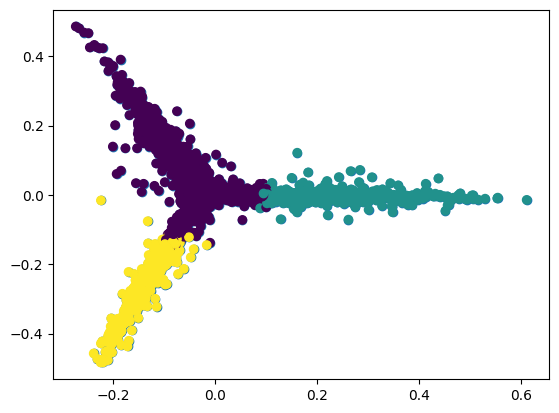

In [17]:
# K-Means++
def kmeansPlus(n, data):
    # decompose
    pcaVec = PCA(n_components=n, random_state=42)
    pca = pcaVec.fit_transform(data)

    kmp = KMeans(n_clusters = n, init = 'k-means++')
    fit = kmp.fit(pca)
    label = kmp.labels_

    # plot scatter
    plt.scatter(pca[:, 0], pca[:, 1])
    plt.scatter(pca[:, 0], pca[:, 1], c = label)
    return fit

kmpx = kmeansPlus(3, bona_sr_tfidf)
print(kmpx)

# Spherical K-Means
# skm = SphericalKMeans(n_clusters=n)
# skm.fit(X)

# skm.cluster_centers_
# skm.labels_
# skm.inertia_

Performance Analysis

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_mutual_info_score

# Silhouette Score
# silhouette_score(labels_true, labels_pred)

# Purity
# contingency_matrix(labels_true, labels_pred)

# AMI
# adjusted_mutual_info_score(labels_true, labels_pred)